In [22]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import pickle

df = pd.read_csv("ecommerce_dataset.csv")

df = df[["id", "name", "categories", "manufacturerNumber", "manufacturer", "reviews.username", "reviews.rating"]]

print(df.count())



id                    71044
name                  71044
categories            71044
manufacturerNumber    70841
manufacturer          70903
reviews.username      70948
reviews.rating        71044
dtype: int64


In [56]:
df.head(4)

,id,name,categories,manufacturerNumber,manufacturer,reviews.username,reviews.rating
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",14331328,Universal Music Group / Cash Money,Joshua,5
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",574764,Lundberg,Dorothy W,5
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",574764,Lundberg,Dorothy W,5
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",67981934427,K-Y,Rebecca,1


In [74]:
different_users = df["reviews.username"].nunique()
different_products = df["id"].nunique()
different_vendors = df["manufacturer"].nunique()

print("total users:", different_users)
print("total products:", different_products)
print("total vendors:", different_vendors)

total users: 58088
total products: 600
total vendors: 463


In [75]:
df = df.rename(columns={ "id" : "productId", "name": "productName", "manufacturer": "vendorName", "manufacturerNumber": "vendorId", "reviews.username": "user", "reviews.rating": "rating" })
df.head(1)

,productId,productName,categories,vendorId,vendorName,user,rating
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",14331328,Universal Music Group / Cash Money,Joshua,5


In [97]:
df_metadata = df.loc[:, ["productId", "productName", "vendorId", "vendorName", "categories"]]
df_metadata['productName'].str.strip()
df_metadata['vendorName'].str.strip()
df_metadata['vendorId'].str.strip()

df_metadata['vendorId'] = df.groupby('vendorName').ngroup()
df_metadata = df_metadata.drop_duplicates()
df_metadata.head(5)

,productId,productName,vendorId,vendorName,categories
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),424,Universal Music Group / Cash Money,"Movies, Music & Books,Music,R&b,Movies & TV,Mo..."
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,229,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co..."
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,184,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm..."
30,AV1d76w7vKc47QAVhCqn,"J.R. Watkins Hand Cream, Lemon Cream",165,J.R. Watkins,"Personal Care,Skin Care,Hand Cream,Beauty,Body..."
36,AV1h6gSl-jtxr-f31p40,Ambi Complexion Cleansing Bar,119,FLEMING & CO,"Personal Care,Bath, Shower & Soap,Featured Bra..."


In [98]:
ALL_CATEGORIES = set()

def clean_categories(row):
    global ALL_CATEGORIES
    row = row.split(',')
    row = [category.strip() for category in row if category != '']
    ALL_CATEGORIES = ALL_CATEGORIES.union(set(row))
    return row

df_metadata["categories"] = df_metadata.apply(lambda row: clean_categories(row["categories"]), axis=1)
ALL_CATEGORIES = list(sorted(ALL_CATEGORIES))

In [99]:
import spacy
import re
import string
POS_tagger = spacy.load('en_core_web_trf')

def get_nouns(text, top_n = 5):
    tagged_words = POS_tagger(text.lower())
    nouns_string = ""
    lemma_freq = {}
    for word in tagged_words:
        if word.pos_ == 'NOUN' and not word.is_stop and len(word.shape_) > 1: 
            if word.text not in lemma_freq: lemma_freq[word.text] = 0
            lemma_freq[word.text] += 1
    sort_lemma_freq = sorted(lemma_freq.items(), key=lambda x: x[1], reverse=True)
    
    return sort_lemma_freq[:top_n]

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?¿\]\%#', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s+',' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text


In [100]:
BAG_OF_WORDS = []
df_metadata["vendorName"][22514] = "NaN"
for id, data in df_metadata.iterrows():
    BAG_OF_WORDS = BAG_OF_WORDS + [data["productName"], data["vendorName"]] + data["categories"]

corpus = ' '.join(BAG_OF_WORDS)
corpus = clean_text_round2(clean_text_round1(corpus))
top_nouns = get_nouns(corpus, top_n=150)
top_nouns

<ipython-input-100-3aef0e581185>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metadata["vendorName"][22514] = "NaN"


[('care', 508),
 ('home', 369),
 ('movies', 324),
 ('food', 318),
 ('beauty', 303),
 ('music', 198),
 ('foods', 192),
 ('household', 161),
 ('health', 151),
 ('hair', 138),
 ('body', 127),
 ('supplies', 122),
 ('tv', 121),
 ('decor', 120),
 ('beverage', 104),
 ('accessories', 100),
 ('grocery', 98),
 ('bath', 97),
 ('snacks', 96),
 ('chips', 94),
 ('kitchen', 89),
 ('skin', 78),
 ('baby', 78),
 ('brands', 77),
 ('books', 76),
 ('makeup', 76),
 ('office', 75),
 ('essentials', 73),
 ('lip', 73),
 ('bars', 71),
 ('ways', 70),
 ('shop', 67),
 ('laundry', 67),
 ('cleaning', 65),
 ('tools', 65),
 ('cookies', 63),
 ('products', 63),
 ('lamps', 62),
 ('kids', 60),
 ('furniture', 57),
 ('face', 54),
 ('cleaners', 53),
 ('lighting', 53),
 ('conditioner', 51),
 ('blu', 51),
 ('ray', 51),
 ('vinyl', 49),
 ('shows', 49),
 ('improvement', 49),
 ('cd', 46),
 ('treatments', 45),
 ('shower', 43),
 ('shampoo', 43),
 ('wall', 42),
 ('bathroom', 42),
 ('styling', 42),
 ('dvd', 41),
 ('cream', 41),
 ('grai

In [102]:
df_metadata.to_csv("files/elastic_data.csv")
with open("files/top_nouns.pkl", "wb") as file:
    pickle.dump(top_nouns, file)
    file.close()
df_metadata.to_csv("files/elastic_data.csv")

In [103]:
from elasticsearch import Elasticsearch

with open("files/top_nouns.pkl", "rb") as file:
    top_nouns = pickle.load(file)
    file.close()

es = Elasticsearch(
    ["https://elastic.jolguin.tk"],
    http_auth=("elastic", "kxqGA8L1Zu5Ax7p"),
    scheme="http"
)

es_queries_results = {}

for query_text, freq in top_nouns:
  search_dict = {
    "query": {
      "bool": {
        "should": [
          {
            "multi_match": {
              "query": query_text,
              "fields": ["productName^3", "vendorName", "categories"],
            }
          }
        ]
      }
    },
    'size': 100,
  }
  response = es.search(index="sog_eval_data", body=search_dict)['hits']['hits']
  es_queries_results[query_text] = response

es_queries_results

{'care': [{'_index': 'sog_eval_data',
   '_type': '_doc',
   '_id': 'w5wo83wBzWC9L5hpuIzJ',
   '_score': 14.041701,
   '_source': {'productId': 'AVpfbpzd1cnluZ0-kqJV',
    'dataset_index': 17800,
    'vendorId': 83,
    'categories': "['Household Chemicals', 'Laundry', 'Bleach Products', 'Household Essentials', 'Laundry Care', 'Health & Household', 'Household Supplies', 'Bleach', 'Featured Brands', 'Home And Storage & Org', 'Clorox', 'Grocery']",
    'vendorName': 'Clorox',
    'productName': 'Clorox Ultimate Care Premium Bleach'}},
  {'_index': 'sog_eval_data',
   '_type': '_doc',
   '_id': 'P5wo83wBzWC9L5hpuI3K',
   '_score': 13.164644,
   '_source': {'productId': 'AVpfrfHF1cnluZ0-pRai',
    'dataset_index': 27422,
    'vendorId': 362,
    'categories': "['Personal Care', 'Hair Care', 'Conditioner', 'Styling Products', 'Beauty', 'Health & Beauty', 'Hair Care & Styling', 'Other Hair Care & Styling', 'Conditioners', 'See more Care Free Curl Soft Sheen Curl Enhancer Activa...', 'Hair St

In [105]:
with open("files/es_queries_results.pkl", "wb") as file:
    pickle.dump(es_queries_results, file)
    file.close()

# Build Products SIM Matrix

In [106]:
import numpy as np
import scipy.sparse as sp

UNIQUE_PRODUCTS = list(df_metadata["productName"].unique())
row_ind = []
col_ind = []
data = []
for index, row in df_metadata.iterrows():
    for category in row["categories"]:
        row_ind.append(UNIQUE_PRODUCTS.index(row["productName"]))
        col_ind.append(ALL_CATEGORIES.index(category))
        data.append(1)
X = sp.csr_matrix((data, (row_ind, col_ind)), shape=(len(UNIQUE_PRODUCTS), len(ALL_CATEGORIES)))

num = np.dot(X, X.T).toarray()
num_diag = np.diag(np.diag(num))
a = np.dot(num_diag, np.ones(num_diag.shape))
b = a.T
den = a + b - num
jaccard_matrix = np.true_divide(num, den)
jaccard_matrix

with open("files/products_categories_matrix.pkl", "wb") as file:
    pickle.dump(X, file)
    file.close()
with open("files/jacc_sim_matrix.pkl", "wb") as file:
    pickle.dump(jaccard_matrix, file)
    file.close()
with open("files/unique_products.pkl", "wb") as file:
    pickle.dump(UNIQUE_PRODUCTS, file)
    file.close()


# Setting SOG env

In [107]:
import pickle
import scipy.sparse as sp

with open("files/es_queries_results.pkl", "rb") as file:
    es_queries_results = pickle.load(file)
    file.close()
with open("files/jacc_sim_matrix.pkl", "rb") as file:
    SIM_MATRIX = pickle.load(file)
    file.close()
with open("files/unique_products.pkl", "rb") as file:
    UNIQUE_PRODUCTS = pickle.load(file)
    file.close()
with open("files/products_categories_matrix.pkl", "rb") as file:
    X = pickle.load(file)
    file.close()
UNPOP = X.sum(1)/X.shape[1]
UNPOP *= 10

def SOG_score_elastic(doc, candidate_set, unique_products, sim_matrix, unpop):

    ES_SOG_REL_PARAM_W = 0.2
    ES_SOG_DIV_PARAM_W = 0.4
    ES_SOG_UNPOP_I_PARAM_W = 0.2
    ES_SOG_DIV_VEN_PARAM_W = 0.2
    score = 0
    div_iB = 0
    n = 0
    product_index = unique_products.index(doc['_source']['productName'])
    product_vendor = doc['_source']['vendorName']
    unpop_i = unpop[product_index]
    for candidate_doc in candidate_set:
        candidate_vendor = candidate_doc['_source']['vendorName']
        candidate_index = unique_products.index(candidate_doc['_source']['productName'])
        div_iB += (1 - sim_matrix[product_index][candidate_index])
        if product_vendor == candidate_vendor: n += 1
    product_score = doc['_score']
    div_vendor_iB = 1/(n+1)

    #comparar doc_vendor contra todos los vendors del candidate_Set
    #Si no lo encontramos (doc_vendor) se le asigna prob V.import
    #Si lo encontramos se le asigna prob V/n+1 donde n es la cantidad de apariciones en candidate_Set
    score += ES_SOG_REL_PARAM_W     * product_score                     \
          +  ES_SOG_DIV_PARAM_W     * (div_iB/len(candidate_set))       \
          +  ES_SOG_UNPOP_I_PARAM_W * unpop_i                           \
          +  ES_SOG_DIV_VEN_PARAM_W * div_vendor_iB
          #+  ES_SOG_PROF_UI_PARAM_W * prof_ui.get(int(doc['_id']), 0)   \
    return score

def ES_SOG(response):
    max_doc_score = response[0]['_score']
    for doc in response:
        doc['_score'] /= max_doc_score

    SOG_response = []
    SOG_response.append(response.pop(0))
    for _ in range(len(response)):  # iterate through top docs ---- SOG
        max_score = -1
        for doc in response: 
            score = SOG_score_elastic(doc, SOG_response, UNIQUE_PRODUCTS, SIM_MATRIX, UNPOP)
            if score > max_score:
                max_score = score
                best_doc = doc
        SOG_response.append(response.pop(response.index(best_doc)))
    return SOG_response

# Running SOG

In [108]:
final_results = {}
for query in es_queries_results:
    ES_response = es_queries_results[query]
    SOG_response = ES_SOG(ES_response[:])
    final_results[query] = {
        'ES_response' : ES_response,
        'SOG_response' : SOG_response
    }
with open("files/final_results.pkl", "wb") as file:
    pickle.dump(final_results, file)
    file.close()

# ES_SOG evaluation

In [39]:
import pickle 
with open("files/ES/final_results.pkl", "rb") as file:
    final_results = pickle.load(file)
    file.close()
with open("files/ES/jacc_sim_matrix.pkl", "rb") as file:
    SIM_MATRIX = pickle.load(file)
    file.close()
with open("files/ES/unique_products.pkl", "rb") as file:
    UNIQUE_PRODUCTS = pickle.load(file)
    file.close()

# Evaluación ES vs ES + SOG

In [36]:
cont = 0
for query in final_results:
    if len(final_results[query]['ES_response']) < 10: 
        print(query, len(final_results[query]['ES_response']))
        cont += 1
cont

deodorants 9
men 7
bedding 9
rice 8
yogurt 6
sun 9
security 4
fans 8
folders 7
candy 8


10

## Ideas

- Para cada item contar la cantidad de veces que quedó en cada puesto
    - e.g: { item_0: { 1: n_1, 2: n_2, ..., 10: n_10 }, ... }
- Medir cuantas veces aparece EN LA MISMA QUERY una tienda, pero ya que no esta dentro de nuestros supuestos, hacer uan discusión sobre esto. Tomar el mejor ranking de todos los productos de la tienda que aparezcan
- Discutir probabilidad de click != visibilidad... Visibilidad no es un concepto realmente definido, explicar desde el punto de vista de nuestra propuesta, es decir, que aparezca dentro de la respuesta. Visibilidad sería que tan probable es que un usuario VEA la tienda no que le haga click
- Modelo de ranking de currency, 

## Gini

- Calcular la suma de las diferencias de visibilidad de vendors por query.
- Generar funciones que "miden la visibilidad":
    - Binaria: Aparece en la recomendación (1) o no (0)
    - Rankeada: Mientras más arriba en el ranking más score. E.g: score = 100 - r_i 

In [4]:
from scipy.stats import logistic
import numpy as np
import pickle 
with open("files/ES/final_results.pkl", "rb") as file:
    final_results = pickle.load(file)
    file.close()
with open("files/ES/jacc_sim_matrix.pkl", "rb") as file:
    SIM_MATRIX = pickle.load(file)
    file.close()
with open("files/ES/unique_products.pkl", "rb") as file:
    UNIQUE_PRODUCTS = pickle.load(file)
    file.close()

with open('files/utils/product_vendor_pairs.pkl', 'rb') as file:
    products_and_vendors_dict = pickle.load(file)
    file.close()


def get_product_vendor(product_id):
    return products_and_vendors_dict[product_id]
def lineal_ranking_score(ranking, n):
    return n - ranking

def logistic_ranking_score(ranking, n):
    return n*(1 - logistic.cdf(ranking, loc=n/4, scale=n/20))

def binary_visibility_at_n(visibility_dict, response, is_ES, n, unique_items):
    if is_ES:
        checked_vendors = []
        for doc in response[:n]:
            id = doc['_source']['vendorId']
            if id not in checked_vendors:
                visibility_dict[id] += 1
                checked_vendors.append(id)
    else:
        checked_vendors = []
        for product_index, rating in response[:n]:
            id = get_product_vendor(unique_items[product_index])
            if id not in checked_vendors:
                visibility_dict[id] += 1
                checked_vendors.append(id)

def ranked_visibility(visibility_dict, response, is_ES, n, rank_score_func, unique_items):
    if is_ES:
        for ranking, doc in enumerate(response):
            id = doc['_source']['vendorId']
            visibility_dict[id] += rank_score_func(ranking, n)
    else:
        for ranking, (product_index, rating) in enumerate(response):
            id = get_product_vendor(unique_items[product_index])
            visibility_dict[id] += rank_score_func(ranking, n)

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def get_vendors_visibility_array(
        products_and_vendors_dict, 
        responses, 
        algorithm_response, 
        is_ES, 
        is_binary,
        unique_items,
        binary_n=10, 
        ranked_score_func= lineal_ranking_score
    ):
    vendors_visibility = { vendorId: 0 for _, vendorId in products_and_vendors_dict.items() }
    if is_ES:
        for query, response_pair in responses.items():
            #print(len(response_pair[algorithm_response]))
            if is_binary:
                binary_visibility_at_n(vendors_visibility, response_pair[algorithm_response], is_ES, binary_n, unique_items)
            else:
                ranked_visibility(vendors_visibility, response_pair[algorithm_response], is_ES, 100, ranked_score_func, unique_items)
    else:
        for user, response_pair in responses.items():
            if is_binary:
                binary_visibility_at_n(vendors_visibility, response_pair[algorithm_response], is_ES, binary_n, unique_items)
            else:
                ranked_visibility(vendors_visibility, response_pair[algorithm_response], is_ES, 20, ranked_score_func, unique_items)
    return np.array([score for _, score in vendors_visibility.items()])

binary n = 5
CF ranked Gini: 0.4738461828037946
CF SOG ranked Gini: 0.4584063249124101
--------------------------------------------------
binary n = 10
CF ranked Gini: 0.35509769244824974
CF SOG ranked Gini: 0.31769012753897025
--------------------------------------------------
binary n = 25
CF ranked Gini: 0.28847091768840194
CF SOG ranked Gini: 0.2583446540353565
--------------------------------------------------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


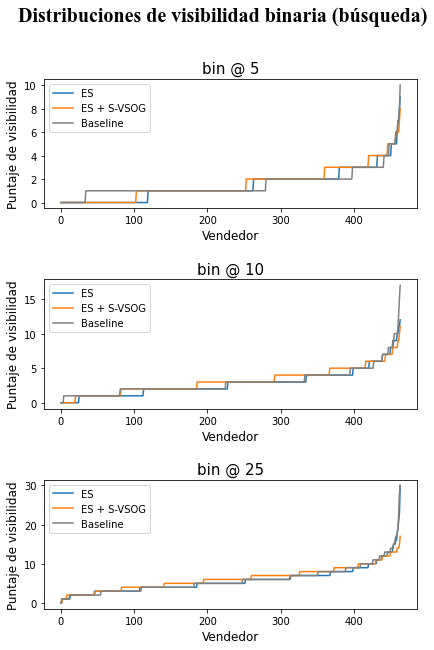

In [5]:
with open('files/ES/baseline.pkl', 'rb') as file:
    baseline = pickle.load(file)
    file.close()
import matplotlib.pylab as plt
n = [5, 10, 25]
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(7, 10)
fig.suptitle('Distribuciones de visibilidad binaria (búsqueda)', fontsize=20, fontweight='bold', fontfamily='Times New Roman', y=0.93)
fig.tight_layout(pad=5)

ES_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='ES_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=n[0])
ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=n[0])

ES_gini_b_5 = gini_coefficient(ES_visibility)
ES_SOG_gini_b_5 = gini_coefficient(ES_SOG_visibility)


ax1.plot(sorted(ES_visibility), label= 'ES')
ax1.plot(sorted(ES_SOG_visibility), label = 'ES + S-VSOG')
ax1.plot(sorted(baseline[9][0]), label = 'Baseline', color='grey')
ax1.set_title(f'bin @ {n[0]}', fontsize=15)
ax1.legend(loc='best')
ax1.set_xlabel('Vendedor', fontsize=12)
ax1.set_ylabel('Puntaje de visibilidad', fontsize=12)
# ax1.set_yscale('log')

print(f'binary n = {n[0]}\nCF ranked Gini: {ES_gini_b_5}\nCF SOG ranked Gini: {ES_SOG_gini_b_5}')
print('-'*50)

ES_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='ES_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=n[1])
ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=n[1])

ES_gini_b_10 = gini_coefficient(ES_visibility)
ES_SOG_gini_b_10 = gini_coefficient(ES_SOG_visibility)


ax2.plot(sorted(ES_visibility), label= 'ES')
ax2.plot(sorted(ES_SOG_visibility), label = 'ES + S-VSOG')
ax2.plot(sorted(baseline[9][1]), label = 'Baseline', color='grey')
ax2.set_title(f'bin @ {n[1]}', fontsize=15)
ax2.legend(loc='best')
ax2.set_xlabel('Vendedor', fontsize=12)
ax2.set_ylabel('Puntaje de visibilidad', fontsize=12)
# ax2.set_yscale('log')

print(f'binary n = {n[1]}\nCF ranked Gini: {ES_gini_b_10}\nCF SOG ranked Gini: {ES_SOG_gini_b_10}')
print('-'*50)

ES_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='ES_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=n[2])
ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=n[2])

ES_gini_b_25 = gini_coefficient(ES_visibility)
ES_SOG_gini_b_25 = gini_coefficient(ES_SOG_visibility)


ax3.plot(sorted(ES_visibility), label= 'ES')
ax3.plot(sorted(ES_SOG_visibility), label = 'ES + S-VSOG')
ax3.plot(sorted(baseline[9][2]), label = 'Baseline', color='grey')
ax3.set_title(f'bin @ {n[2]}', fontsize=15)
ax3.legend(loc='best')
ax3.set_xlabel('Vendedor', fontsize=12)
ax3.set_ylabel('Puntaje de visibilidad', fontsize=12)
# ax3.set_yscale('log')

print(f'binary n = {n[2]}\nCF ranked Gini: {ES_gini_b_25}\nCF SOG ranked Gini: {ES_SOG_gini_b_25}')
print('-'*50)

fig.savefig(r'C:\Users\crist\OneDrive\Desktop\Memoria\images\graphs\es_binary_visibility_distr.eps', bbox_inches='tight', format='eps')

rank func: lineal
ES ranked Gini: 0.3455275534831299
ES SOG ranked Gini: 0.29285875845886095
--------------------------------------------------
rank func: logistic
ES ranked Gini: 0.3437311721249565
ES SOG ranked Gini: 0.26208485261609293


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


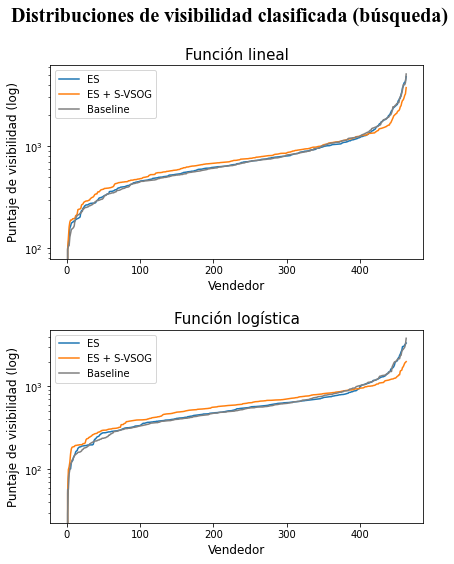

In [6]:
# binary_visibility_at_n(final_results['food']['ES_response'], 10, True)
# binary_visibility_at_n(final_results['food']['SOG_response'], 10, True)
# ranked_visibility(final_results['food']['SOG_response'], 10, True)
import matplotlib.pylab as plt
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(7, 9)
fig.suptitle('Distribuciones de visibilidad clasificada (búsqueda)', fontsize=20, fontweight='bold', fontfamily='Times New Roman', y=0.9)
fig.tight_layout(pad=5)

ES_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='ES_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=False, binary_n=n, ranked_score_func=lineal_ranking_score)
ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=False, binary_n=n, ranked_score_func=lineal_ranking_score)

ES_gini_r_lnl = gini_coefficient(ES_visibility)
ES_SOG_gini_r_lnl = gini_coefficient(ES_SOG_visibility)

ax1.plot(sorted(ES_visibility), label= 'ES')
ax1.plot(sorted(ES_SOG_visibility), label = 'ES + S-VSOG')
ax1.plot(sorted(baseline[9][3]), label = 'Baseline', color='grey')
ax1.set_title('Función lineal', fontsize=15)
ax1.legend(loc='best')
ax1.set_xlabel('Vendedor', fontsize=12)
ax1.set_ylabel('Puntaje de visibilidad (log)', fontsize=12)
ax1.set_yscale('log')

print(f'rank func: lineal\nES ranked Gini: {ES_gini_r_lnl}\nES SOG ranked Gini: {ES_SOG_gini_r_lnl}')
print('-'*50)
ES_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='ES_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=False, binary_n=n, ranked_score_func=logistic_ranking_score)
ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, final_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=False, binary_n=n, ranked_score_func=logistic_ranking_score)

ES_gini_r_lgstc = gini_coefficient(ES_visibility)
ES_SOG_gini_r_lgstc = gini_coefficient(ES_SOG_visibility)

ax2.plot(sorted(ES_visibility), label= 'ES')
ax2.plot(sorted(ES_SOG_visibility), label = 'ES + S-VSOG')
ax2.plot(sorted(baseline[9][4]), label = 'Baseline', color='grey')
ax2.set_title('Función logística', fontsize=15)
ax2.legend(loc='best')
ax2.set_xlabel('Vendedor', fontsize=12)
ax2.set_ylabel('Puntaje de visibilidad (log)', fontsize=12)
ax2.set_yscale('log')

print(f'rank func: logistic\nES ranked Gini: {ES_gini_r_lgstc}\nES SOG ranked Gini: {ES_SOG_gini_r_lgstc}')

fig.savefig(r'C:\Users\crist\OneDrive\Desktop\Memoria\images\graphs\es_ranked_visibility_distr.eps', bbox_inches='tight', format='eps')

In [7]:
import math
from sklearn.metrics import auc
import copy
import random

def simplify_es_response(response, atrib='idx'):
    if atrib == 'idx': return [UNIQUE_PRODUCTS.index(doc['_source']['productId']) for doc in response]
    else: return [doc['_score'] for doc in response]

def simplify_user_search_pair(recommendation_pair, atrib):
    return {
        'ES_response': simplify_es_response(recommendation_pair['ES_response'], atrib),
        'SOG_response': simplify_es_response(recommendation_pair['SOG_response'], atrib)
    } 
def simplify_es_final_results(final_results, atrib):
    simplified_results = {}
    for query, response_pair in final_results.items():
        simplified_results[query] = simplify_user_search_pair(response_pair, atrib)
    return simplified_results

######## MEAN AVERAGE PRECISION #########

def column_sum(M):
    return [sum(i) for i in zip(*M)]
"""def intersection(lst1, lst2):
    return len(set(lst1).intersection(set(lst2)))
def precision_at_n_array(t_user, t_user_results, N):
    return [intersection(t_user_results[:n], VAL_USERS_RELEVANT_PRODUCTS[t_user])/n for n in N]
def mean_average_precision_at_n_cf(final_results, n):
    M_cf = []
    M_sog = []
    for user, response_pair in final_results.items():
        M_cf.append(precision_at_n_array(user, response_pair['ES_response'], range(1, n+1)))
        M_sog.append(precision_at_n_array(user, response_pair['SOG_response'], range(1, n+1)))
    M_cf = sum(column_sum(M_cf))
    M_sog = sum(column_sum(M_sog))
    div = n*len(final_results)
    return M_cf/div, M_sog/div"""

######## RECALL AUC #########

"""def recall_at_n(t_user, t_user_results, N):
    return [intersection(t_user_results[:n], VAL_USERS_RELEVANT_PRODUCTS[t_user])/len(VAL_USERS_RELEVANT_PRODUCTS[t_user]) for n in N]
def avg_recal_auc(final_results, n):
    M_cf = []
    M_sog = []
    for user, response_pair in final_results.items():
        M_cf.append( auc(range(1, n+1), recall_at_n(user, response_pair['ES_response'], range(1, n+1))) )
        M_sog.append( auc(range(1, n+1), recall_at_n(user, response_pair['SOG_response'], range(1, n+1))) )
    return sum(M_cf)/len(final_results), sum(M_sog)/len(final_results)
"""
######## RELEVANCE NDCG #########

def DCG(ratings_array):
    return sum([ratings_array[0]] + [ r/math.log2(i+2) for i, r in enumerate(ratings_array[1:]) ])

def mean_NDCG(final_results):
    return sum( DCG(r_response_pair['SOG_response'])/DCG(r_response_pair['ES_response']) for r_response_pair in final_results.values() )/len(final_results)

######## MEAN AVERAGE DIVERISTY #########

def diversity_at_n_array(indexes_array, N):
    return [ (sum([(1 - SIM_MATRIX[i, j]) for i in indexes_array[:n] for j in indexes_array[:n] if i!=j])/(n*(n-1))) if n <= len(indexes_array) else 0 for n in N ]

def mean_average_diversity_at_n(final_results, n):
    M_cf = []
    M_sog = []
    for response_pair in final_results.values():
        M_cf.append(diversity_at_n_array(response_pair['ES_response'], range(2, n+1)))
        M_sog.append(diversity_at_n_array(response_pair['SOG_response'], range(2, n+1)))
    M_cf = sum(column_sum(M_cf))
    M_sog = sum(column_sum(M_sog))
    div = n*len(final_results)
    return M_cf/div, M_sog/div

######## BASELINE METHODS #########
import random
from collections import defaultdict
def get_baseline(final_results, samples, n):
    shuffled_results = {}
    S_map_at_n = 0
    S_rcll_auc_at_n = 0
    S_mad_at_n = 0
    S_ndcg = 0
    S_gini_b_5 = 0
    S_gini_b_10 = 0
    S_gini_b_25 = 0
    S_gini_r_lnl = 0
    S_gini_r_lgstc = 0
    baseline_visibility_distributions = defaultdict(list)
    for i in range(samples):
        for user, response_pair in final_results.items():
            dummy = copy.deepcopy(response_pair['ES_response'])
            random.shuffle(dummy)
            shuffled_results[user] = {
                'ES_response': response_pair['ES_response'],
                'SOG_response':  dummy
            }
        simplified_results_idx = simplify_es_final_results(shuffled_results, 'idx')
        simplified_results_score = simplify_es_final_results(shuffled_results, 'score')

        #S_map_at_n += mean_average_precision_at_n_cf(simplified_results_id, n)[1]
        #S_rcll_auc_at_n += avg_recal_auc(simplified_results_id, n)[1]
        S_ndcg += mean_NDCG(simplified_results_score)
        S_mad_at_n += mean_average_diversity_at_n(simplified_results_idx, n)[1]

        ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, shuffled_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=5)
        S_gini_b_5 += gini_coefficient(ES_SOG_visibility)
        baseline_visibility_distributions[0].append(ES_SOG_visibility)
        ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, shuffled_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=10)
        S_gini_b_10 += gini_coefficient(ES_SOG_visibility)
        baseline_visibility_distributions[1].append(ES_SOG_visibility)
        ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, shuffled_results, algorithm_response='SOG_response',
                                    is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=True, binary_n=25)
        S_gini_b_25 += gini_coefficient(ES_SOG_visibility)
        baseline_visibility_distributions[2].append(ES_SOG_visibility)
        ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, shuffled_results, algorithm_response='SOG_response',
                                            is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=False, binary_n=n, ranked_score_func=lineal_ranking_score)
        S_gini_r_lnl += gini_coefficient(ES_SOG_visibility)
        baseline_visibility_distributions[3].append(ES_SOG_visibility)  
        ES_SOG_visibility = get_vendors_visibility_array(products_and_vendors_dict, shuffled_results, algorithm_response='SOG_response',
                                            is_ES=True, unique_items=UNIQUE_PRODUCTS, is_binary=False, binary_n=n, ranked_score_func=logistic_ranking_score)
        S_gini_r_lgstc += gini_coefficient(ES_SOG_visibility)
        baseline_visibility_distributions[4].append(ES_SOG_visibility)
    for i, M in baseline_visibility_distributions.items():
        baseline_visibility_distributions[i] = [round(S/samples) for S in column_sum(M)]
    
    return (
        S_map_at_n/samples,
        S_rcll_auc_at_n/samples, 
        S_mad_at_n/samples, 
        S_ndcg/samples, 
        S_gini_b_5/samples, 
        S_gini_b_10/samples, 
        S_gini_b_25/samples, 
        S_gini_r_lnl/samples, 
        S_gini_r_lgstc/samples,
        baseline_visibility_distributions
    )

# baseline = get_baseline(final_results, 100, 20)
# with open('files/ES/baseline.pkl', 'wb') as file:
#     pickle.dump(baseline, file)
#     file.close()

    

In [12]:
with open('files/ES/baseline.pkl', 'rb') as file:
    baseline = pickle.load(file)
    file.close()
def weird(n):
    if n==1: return auc( range(1, 10+1), [1]*10 )
    return auc( range(1, 10+1), [i/n if i <= n else 1 for i in range(1, 10+1)] )

simplified_results_idx = simplify_es_final_results(final_results, 'idx')
simplified_results_score = simplify_es_final_results(final_results, 'score')

ndcg = mean_NDCG(simplified_results_score)
mad_at_n = mean_average_diversity_at_n(simplified_results_idx, 10)

print(f'\
######## METRICS RESULTS ########\n#\n\
#  MAD @ {n}:  \n\
#      (ES)   {round(100*mad_at_n[0], 2)}\n\
#      (Base) {round(100*baseline[2], 2)}\n\
#      (VSOG) {round(100*mad_at_n[1], 2)}\n\
#  NDCG: \n\
#      (Base) {round(100*baseline[3], 2)}\n\
#      (VSOG) {round(100*ndcg, 2)}\n\
#  BIN VIS @ {3}:  \n\
#      (ES)   {round(100*ES_gini_b_5, 2)}\n\
#      (Base) {round(100*baseline[4], 2)}\n\
#      (VSOG) {round(100*ES_SOG_gini_b_5, 2)}\n\
#  BIN VIS @ {5}:  \n\
#      (ES)   {round(100*ES_gini_b_10, 2)}\n\
#      (Base) {round(100*baseline[5], 2)}\n\
#      (VSOG) {round(100*ES_SOG_gini_b_10, 2)}\n\
#  BIN VIS @ {10}:  \n\
#      (ES)   {round(100*ES_gini_b_25, 2)}\n\
#      (Base) {round(100*baseline[6], 2)}\n\
#      (VSOG) {round(100*ES_SOG_gini_b_25, 2)}\n\
#  RKD VIS LNL:  \n\
#      (ES)   {round(100*ES_gini_r_lnl, 2)}\n\
#      (Base) {round(100*baseline[7], 2)}\n\
#      (VSOG) {round(100*ES_SOG_gini_r_lnl, 2)}\n\
#  RNK VIS LGSTC:  \n\
#      (ES)   {round(100*ES_gini_r_lgstc, 2)}\n\
#      (Base) {round(100*baseline[8], 2)}\n\
#      (VSOG) {round(100*ES_SOG_gini_r_lgstc, 2)}\n#\n\
#################################')

######## METRICS RESULTS ########
#
#  MAD @ [5, 10, 25]:  
#      (ES)   67.42
#      (Base) 67.83
#      (VSOG) 76.11
#  NDCG: 
#      (Base) 86.63
#      (VSOG) 97.07
#  BIN VIS @ 3:  
#      (ES)   47.38
#      (Base) 50.0
#      (VSOG) 45.84
#  BIN VIS @ 5:  
#      (ES)   35.51
#      (Base) 39.92
#      (VSOG) 31.77
#  BIN VIS @ 10:  
#      (ES)   28.85
#      (Base) 32.35
#      (VSOG) 25.83
#  RKD VIS LNL:  
#      (ES)   34.55
#      (Base) 35.48
#      (VSOG) 29.29
#  RNK VIS LGSTC:  
#      (ES)   34.37
#      (Base) 36.71
#      (VSOG) 26.21
#
#################################
